In [2]:
import os
import glob

import numpy as np
import scipy.ndimage

import astropy.io.fits as fits

%matplotlib inline
import matplotlib.pyplot as plt

import pyccl as ccl

import baryon_painter.painter
import baryon_painter.process_SLICS

import cosmotools.pseudo_Cls

pi = np.pi

In [3]:
import importlib

Plot the y map and corresponding kappa map

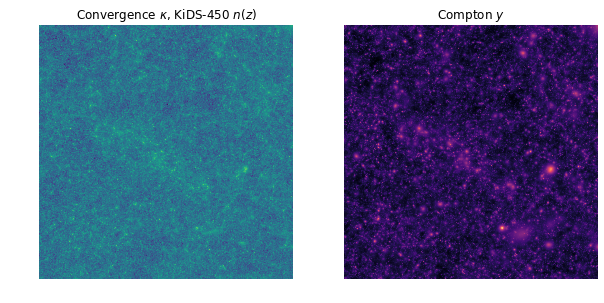

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

ax[0].imshow(np.log(kappa_map[::5,::5]/kappa_map.std()+2))
ax[1].imshow(np.log(y_map[1097]/y_map[1097].std()+0.01), cmap=plt.get_cmap("magma"))

ax[0].axis("off")
ax[0].set_title("Convergence $\kappa$, KiDS-450 $n(z)$")

ax[1].axis("off")
ax[1].set_title("Compton $y$")

fig.savefig("../plots/kappa_y_maps.pdf", pad_inches=0, bbox_inches="tight", dpi=100)

# Paper plots

## Tile plots

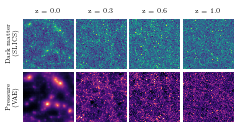

In [654]:
import matplotlib
matplotlib.rc("font", size=6)
matplotlib.rc("font", family="serif")
matplotlib.rc("text", usetex=True)

LOS = 401
n_plane = 4#len(painted_planes[LOS])

column_width = 240.0/72

fig, ax = plt.subplots(2, n_plane, figsize=(column_width, column_width/2))
fig.subplots_adjust(wspace=0.05, hspace=0.05, bottom=0.02, top=0.88, left=0.1, right=0.98)
cmap = plt.get_cmap("magma")

with open(f"../data/training_data/SLICS/tSZ/CVAE/pressure_planes_{LOS}.pickle", "rb") as f:
    painted_planes = pickle.load(f)
    
for i in range(n_plane):
    z = z_SLICS[3*i]
    delta = np.fromfile(f"../data/training_data/SLICS/delta/{z:.3f}delta.dat_bicubic_LOS{LOS}", 
                        dtype=np.float32).reshape(7745, -1).T
    delta = delta[::50,::50] + 96
    
    p = painted_planes[3*i]
    if p.shape[0] > 200:
        p = p[::p.shape[0]//200, ::p.shape[0]//200]
    ax[0,i].imshow(np.log(delta/delta.std() + 0.05), interpolation="none", 
                   extent=(0,d_A_SLICS[3*i]*10/180*pi, 0,d_A_SLICS[3*i]*10/180*pi))
    ax[1,i].imshow(np.log(p/p.std()+0.02), interpolation="none", cmap=cmap, 
                   extent=(0,d_A_SLICS[3*i]*10/180*pi, 0,d_A_SLICS[3*i]*10/180*pi))
        
    ax[0,i].set_title(f"z = {z:.1f}")

[p.set_xticks([]) for p in ax.flatten()]
[p.set_yticks([]) for p in ax.flatten()]

[i.set_linewidth(0) for p in ax.flatten() for i in p.spines.values()]

ax[0,0].set_ylabel("Dark matter\n(SLICS)")
ax[1,0].set_ylabel("Pressure\n(VAE)")
fig.savefig("../paper/overleaf/figures/painted_SLICS.pdf")


## tSZ cross-power plot

In [ ]:
Cl = {"SLICS" : {}}
ell = {}

model2label = {"CVAE_fid"       : "CVAE",
               "CVAE_fid_drop1" : "CVAE",
               "CGAN_fid"       : "CGAN",
               "CGAN_fid_drop1" : "CGAN",}

def cutout(i):
    if i == 5:
        n = 1549
        L = 10.0
        ell_min = 68.52916182
        n_ell = 11
        return (slice(0, n), slice(0, n)), L, ell_min, n_ell
    if i == 4:
        n = 1549//2
        L = 5.0
        ell_min = 100.0
        n_ell = 10
        return (slice(n//2, n//2+n), slice(n//2, n//2+n)), L, ell_min, n_ell
    else:
        n = 1549//2
        L = 5.0
        j = i//2
        k = i%2
        ell_min = 100.0
        n_ell = 10
        return (slice(j*n,(j+1)*n), slice(k*n,(k+1)*n)), L, ell_min, n_ell

idx = 0
for cut_idx in [4,5]:
    cut, L, ell_min, n_ell = cutout(cut_idx)
    for LOS in range(400,501):
        print(f"LOS {LOS} cut {cut}")

        try:
            kappa_map = np.fromfile(f"../data/training_data/SLICS/kappa/KiDS450/kappa_KiDS450_tomo0.dat_LOS{LOS}", dtype=np.float32).reshape(7745, -1, order="F")
        except FileNotFoundError:
            print(f"LOS {LOS} not available.")
            continue
        kappa_map = kappa_map[::5,::5]
        kappa_map = kappa_map[cut]
        kappa_map *= 64

        Cl["SLICS"][idx] = {}
        Cl["SLICS"][idx]["shear-shear"], _, ell[L], _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                          kappa_map, kappa_map, 
                                                          box_size=(L/180*pi, L/180*pi),
                                                          n_bin=n_ell, ell_min=ell_min, ell_max=3000, logspaced=True)
        for model in ["CVAE_fid",
                      "CGAN_fid"
                     ]:
            if model not in Cl: Cl[model] = {}
            Cl[model][idx] = {}
            y_map = np.load(f"../data/training_data/SLICS/tSZ/{model2label[model]}/y_map_{LOS}.npy")
            y_map = y_map[cut]
            Cl[model][idx]["shear-y"], _, ell[L], _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                          y_map, kappa_map, 
                                                          box_size=(L/180*pi, L/180*pi),
                                                          n_bin=n_ell, ell_min=ell_min, ell_max=3000, logspaced=True)
            Cl[model][idx]["y-y"], _, ell[L], _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                          y_map, y_map, 
                                                          box_size=(L/180*pi, L/180*pi),
                                                          n_bin=n_ell, ell_min=ell_min, ell_max=3000, logspaced=True)

        for model in ["CVAE_fid_drop1",
                      "CGAN_fid_drop1"
                     ]:
            if model not in Cl: Cl[model] = {}
            Cl[model][idx] = {}
            y_map = np.load(f"../data/training_data/SLICS/tSZ/{model2label[model]}/y_map_{LOS}_drop_1.npy")
            y_map = y_map[cut]

            Cl[model][idx]["shear-y"], _, ell[L], _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                          y_map, kappa_map, 
                                                          box_size=(L/180*pi, L/180*pi),
                                                          n_bin=n_ell, ell_min=ell_min, ell_max=3000, logspaced=True)
            Cl[model][idx]["y-y"], _, ell[L], _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                          y_map, y_map, 
                                                          box_size=(L/180*pi, L/180*pi),
                                                          n_bin=n_ell, ell_min=ell_min, ell_max=3000, logspaced=True)
        idx += 1

In [589]:
Cl_BAHAMAS = {"shear-shear" : {}, "shear-y" : {}, "y-y" : {}, "shear-shear-DMONLY" : {},}
Cl_BAHAMAS["shear-shear"]["LOS"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190325/BAHAMAS_wide_bin/TUNED/shear_shear_cl_binned/LOS_1_1.txt")
Cl_BAHAMAS["shear-shear"]["mean"] = Cl_BAHAMAS["shear-shear"]["LOS"].mean(axis=0)
Cl_BAHAMAS["shear-shear"]["std"] = Cl_BAHAMAS["shear-shear"]["LOS"].std(axis=0, ddof=1)
Cl_BAHAMAS["shear-shear"]["var"] = Cl_BAHAMAS["shear-shear"]["LOS"].var(axis=0, ddof=1)
Cl_BAHAMAS["shear-shear"]["ell"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190325/BAHAMAS_wide_bin/TUNED/shear_shear_cl_binned/ell.txt")

Cl_BAHAMAS["shear-shear-DMONLY"]["LOS"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190325/BAHAMAS_wide_bin/DMONLY/shear_shear_cl_binned/LOS_1_1.txt")
Cl_BAHAMAS["shear-shear-DMONLY"]["mean"] = Cl_BAHAMAS["shear-shear-DMONLY"]["LOS"].mean(axis=0)
Cl_BAHAMAS["shear-shear-DMONLY"]["std"] = Cl_BAHAMAS["shear-shear-DMONLY"]["LOS"].std(axis=0, ddof=1)
Cl_BAHAMAS["shear-shear-DMONLY"]["var"] = Cl_BAHAMAS["shear-shear-DMONLY"]["LOS"].var(axis=0, ddof=1)
Cl_BAHAMAS["shear-shear-DMONLY"]["ell"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190325/BAHAMAS_wide_bin/DMONLY/shear_shear_cl_binned/ell.txt")

Cl_BAHAMAS["shear-y"]["LOS"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190325/BAHAMAS_wide_bin/TUNED/shear_y_cl_binned/LOS_1_1.txt")
Cl_BAHAMAS["shear-y"]["mean"] = Cl_BAHAMAS["shear-y"]["LOS"].mean(axis=0)
Cl_BAHAMAS["shear-y"]["std"] = Cl_BAHAMAS["shear-y"]["LOS"].std(axis=0, ddof=1)
Cl_BAHAMAS["shear-y"]["var"] = Cl_BAHAMAS["shear-y"]["LOS"].var(axis=0, ddof=1)
Cl_BAHAMAS["shear-y"]["ell"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190325/BAHAMAS_wide_bin/TUNED/shear_y_cl_binned/ell.txt")

Cl_BAHAMAS["y-y"]["LOS"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190308/BAHAMAS_wide_bin/TUNED/y_y_cl_binned/LOS_1_1.txt")
Cl_BAHAMAS["y-y"]["mean"] = Cl_BAHAMAS["y-y"]["LOS"].mean(axis=0)
Cl_BAHAMAS["y-y"]["std"] = Cl_BAHAMAS["y-y"]["LOS"].std(axis=0, ddof=1)
Cl_BAHAMAS["y-y"]["var"] = Cl_BAHAMAS["y-y"]["LOS"].var(axis=0, ddof=1)
Cl_BAHAMAS["y-y"]["ell"] = np.loadtxt("/Users/yooken/Research/project_triad/results/20190308/BAHAMAS_wide_bin/TUNED/y_y_cl_binned/ell.txt")

In [364]:
def bootstrap(data, n, axis=0, func=np.var, func_kwargs={"ddof" : 1}):
    assert axis == 0, "Only axis == 0 supported for now."
    
    if isinstance(data, list):
        assert all([d.shape[1:] == data[0].shape[1:] for d in data])
        samples = np.zeros((n, *data[0].shape[1:]), dtype=data[0].dtype)
    else:
        samples = np.zeros([data.shape[i] if i != axis else n for i in range(data.ndim)], 
                           dtype=data.dtype)
    
    for i in range(n):
        if isinstance(data, list):
            idx = [np.random.choice(d.shape[0], size=d.shape[0], replace=True) for d in data]
            samples[i] = func([d[i] for d, i in zip(data, idx)], axis=axis, **func_kwargs)
        else:
            idx = np.random.choice(data.shape[axis], size=data.shape[axis], replace=True)
            samples[i] = func(data[idx], axis=axis, **func_kwargs)

    return samples

def bootstrap_var(data, n, axis=0, func=np.var, func_kwargs={"ddof" : 1}):
    samples = bootstrap(data, n, axis, func, func_kwargs)
    return samples.var(axis=axis, ddof=1)

def scaled_var(data, axis=0, scale=1):
    return data.var(axis=axis, ddof=1)*scale

def ratio_of_mean(data, axis=0):
    return data[0].mean(axis=axis)/data[1].mean(axis=axis)-1

def ratio_of_var(data, axis=0, ddof=1, scale=1):
    return scale*data[0].var(axis=axis, ddof=ddof)/data[1].var(axis=axis, ddof=ddof)-1

bootstrap_var([np.zeros((5,3,3)), np.zeros((4,3,3))], n=10, func=ratio_of_mean, func_kwargs={}).shape

/Users/yooken/Codes/miniconda/envs/torch/lib/python3.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in true_divide


(3, 3)

In [ ]:
import matplotlib
matplotlib.rc("font", size=6)
matplotlib.rc("font", family="serif")

matplotlib.rc("text", usetex=True)


model2label = {"CVAE_fid"         : "VAE",
               "CGAN_fid"         : "GAN",
               "CVAE_fid_drop1"   : "VAE no z=0",
              "CGAN_fid_drop1"    : "GAN no z=0"}
model2color = {"CVAE_fid"       : "C0",
               "CVAE_fid_drop1" : "C0",
               "CGAN_fid"       : "C1",
               "CGAN_fid_drop1" : "C1",}
model2ls = {"CVAE_fid"      : "-",
            "CVAE_fid_drop1" : "-",
            "CGAN_fid"      : "--",
            "CGAN_fid_drop1" : "--",}

model2alpha = {"CVAE_fid"       : 0.4,
               "CVAE_fid_drop1" : 0.4,
               "CGAN_fid"       : 0.4,
               "CGAN_fid_drop1" : 0.4,}

model2zorder = {"CVAE_fid"       : 20,
                "CVAE_fid_drop1" : 20,
                "CGAN_fid"       : -20,
                "CGAN_fid_drop1" : -20,}

model2offset = {"CVAE_fid"       : 1.0,
                "CVAE_fid_drop1" : 1.0,
                "CGAN_fid"       : 1.05,
                "CGAN_fid_drop1" : 1.05,}

LOS_range = list(range(100, 200))
# LOS_range = list(range(0,100))+list(range(200,300))
# LOS_range = list(range(500,600))

L = 10.0
ell_cut = 1
area_scaling = 4

def correction(shear_y_S, shear_shear_S, shear_y_B, shear_shear_B, area_scaling, power=2):
    alpha_S = shear_y_S.mean(axis=0)/shear_shear_S.mean(axis=0)
    alpha_B = shear_y_B.mean(axis=0)/shear_shear_B.mean(axis=0)
    
    beta_S = shear_shear_S.var(axis=0, ddof=1)
    beta_B = shear_shear_B.var(axis=0, ddof=1)/area_scaling
    
    return (shear_shear_S.mean(axis=0)/shear_shear_B.mean(axis=0))**(power/2), alpha_S**power/alpha_B**power*beta_S/beta_B
    
    
Cl_shear_shear_SLICS = np.array([Cl["SLICS"][LOS][f"shear-shear"] for LOS in LOS_range])

for probe_1 in ["shear", "y"]:
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(column_width, column_width*0.7), 
                           gridspec_kw={"height_ratios" : [2,1]})
    fig.subplots_adjust(right=0.98, top=0.98, left=0.2, bottom=0.15, hspace=0)
        
    for model in ["CVAE_fid", 
#                   "CVAE_fid_drop1", 
                  "CGAN_fid",
#                   "CGAN_fid_drop1"
                 ]:
        ell = ell_of_L[L][ell_cut:]
        u = ell*(ell+1)/(2*pi)
        y = np.array([Cl[model][LOS][f"{probe_1}-y"] for LOS in LOS_range])[:,ell_cut:]
        mean_correction, var_correction = correction(y, Cl_shear_shear_SLICS[:,ell_cut:], 
                                                     Cl_BAHAMAS[f"{probe_1}-y"]["LOS"], Cl_BAHAMAS[f"shear-shear"]["LOS"],
                                                     area_scaling, power=2 if probe_1=="shear" else 4)
        mean_correction = 1
        ax[0].fill_between(ell, 
                           u*(y.mean(axis=0) - y.std(axis=0, ddof=1))/mean_correction,
                           u*(y.mean(axis=0) + y.std(axis=0, ddof=1))/mean_correction,
                           facecolor=model2color[model], alpha=model2alpha[model])
        ax[0].plot(ell, u*y.mean(axis=0)/mean_correction,
                   ls=model2ls[model],
                   c=model2color[model], label=model2label[model])
        
        ax[1].axhline(0, lw=1, c="k")
        ratio = y.mean(axis=0)/mean_correction/Cl_BAHAMAS[f"{probe_1}-y"]["mean"]-1
        ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-y"]["LOS"]], n=100,
                                          func=ratio_of_mean, func_kwargs={}))/mean_correction
        ax[1].fill_between(ell, (ratio-ratio_std), (ratio+ratio_std),
                           facecolor=model2color[model], alpha=model2alpha[model])
        ax[1].plot(ell, ratio,
                   c=model2color[model], ls=model2ls[model], label=model2label[model])

       
    ell_BAHAMAS = Cl_BAHAMAS[f"{probe_1}-y"]["ell"]
    u = ell_BAHAMAS*(ell_BAHAMAS+1)/(2*pi)
    ax[0].fill_between(ell_BAHAMAS, 
                       u*(Cl_BAHAMAS[f"{probe_1}-y"]["mean"]-Cl_BAHAMAS[f"{probe_1}-y"]["std"]/np.sqrt(area_scaling)), 
                       u*(Cl_BAHAMAS[f"{probe_1}-y"]["mean"]+Cl_BAHAMAS[f"{probe_1}-y"]["std"]/np.sqrt(area_scaling)), 
                       facecolor="C2", alpha=0.5, zorder=-10)
    ax[0].plot(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-y"]["mean"], 
               c="C2", zorder=-10, label="BAHAMAS")

    ax[0].tick_params(axis='both', labelsize="small")
    ax[0].legend(fontsize="small", frameon=False)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[1].set_ylim(-0.25, 0.25)
    ax[1].set_xlabel(r"$\ell$", labelpad=0.1, size="medium")
    ax[0].set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$", labelpad=0.1, size="medium")
    ax[1].set_ylabel("Fractional\ndifference", labelpad=0.1, size="medium")

    fig.savefig(f"../paper/overleaf/figures/Cl_{probe_1}-y_painters_vs_BAHAMAS_mean.pdf")
    
    
    
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(column_width, column_width*0.7),
                           gridspec_kw={"height_ratios" : [2,1]})
    fig.subplots_adjust(right=0.98, top=0.98, left=0.2, bottom=0.15, hspace=0)
        
    for model in ["CVAE_fid", 
#                   "CVAE_fid_drop1",
                  "CGAN_fid",
#                   "CGAN_fid_drop1"
                 ]:
        ell = ell_of_L[L][ell_cut:]
        u = ell*(ell+1)/(2*pi)
        y = np.array([Cl[model][LOS][f"{probe_1}-y"] for LOS in LOS_range])[:,ell_cut:]
        mean_correction, var_correction = correction(y, Cl_shear_shear_SLICS[:,ell_cut:], 
                                                     Cl_BAHAMAS[f"{probe_1}-y"]["LOS"], Cl_BAHAMAS[f"shear-shear"]["LOS"],
                                                     area_scaling, power=2 if probe_1=="shear" else 4)
        mean_correction = 1
        var = 1/var_correction*y.var(axis=0, ddof=1)
        var_std = 1/var_correction*np.sqrt(bootstrap_var(y, n=500))
        u = ell**4
        ax[0].fill_between(ell, u*(var-var_std), u*(var+var_std),
                           facecolor=model2color[model], alpha=model2alpha[model])
        ax[0].plot(ell, u*var,
                   c=model2color[model], ls=model2ls[model], label=model2label[model])
        
        ax[1].axhline(0, lw=1, c="k")
        ratio = var/(Cl_BAHAMAS[f"{probe_1}-y"]["var"]/area_scaling)-1
        ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-y"]["LOS"]], n=500,
                                          func=ratio_of_var, func_kwargs={"scale":area_scaling/var_correction}))
        ax[1].fill_between(ell, (ratio-ratio_std), (ratio+ratio_std),
                           facecolor=model2color[model], alpha=model2alpha[model])
        ax[1].plot(ell, ratio,
                   c=model2color[model], ls=model2ls[model], label=model2label[model])
                
    ell_BAHAMAS = Cl_BAHAMAS[f"{probe_1}-y"]["ell"]
    var_std = np.sqrt(bootstrap_var(Cl_BAHAMAS[f"{probe_1}-y"]["LOS"], n=500,
                                    func=scaled_var, func_kwargs={"scale":1/area_scaling}))
    u = ell_BAHAMAS**4
    ax[0].fill_between(ell_BAHAMAS, u*(Cl_BAHAMAS[f"{probe_1}-y"]["var"]/area_scaling - var_std), 
                       u*(Cl_BAHAMAS[f"{probe_1}-y"]["var"]/area_scaling + var_std),
                       facecolor="C2", alpha=0.5, zorder=-10)
    ax[0].plot(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-y"]["var"]/area_scaling, 
               c="C2", zorder=-10, label="BAHAMAS")

    ax[0].tick_params(axis='both', labelsize="small")
    ax[0].legend(fontsize="small", frameon=False)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[1].set_ylim(-1.2, 1.2)
    ax[1].set_xlabel(r"$\ell$", labelpad=0.1, size="medium")
    ax[0].set_ylabel(r"$\ell^4\mathrm{Var}[C_\ell]$", labelpad=0.1, size="medium")
    ax[1].set_ylabel("Fractional\ndifference", labelpad=0.1, size="medium")
    
    fig.savefig(f"../paper/overleaf/figures/Cl_{probe_1}-y_painters_vs_BAHAMAS_var.pdf")
    
#======= Combined, single plot ================ #
    
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(column_width, column_width*0.7), 
                           gridspec_kw={"height_ratios" : [1,1]})
    fig.subplots_adjust(right=0.98, top=0.98, left=0.15, bottom=0.13, hspace=0)
        
    for model in ["CVAE_fid", 
                  "CGAN_fid", 
                  #"CVAE_fid_drop1", 
#                   "CGAN_fid_drop1"
                 ]:
        ell = ell_of_L[L]
        u = ell*(ell+1)/(2*pi)
        y = np.array([Cl[model][LOS][f"{probe_1}-y"] for LOS in LOS_range])
        mean_correction, var_correction = correction(y[:,ell_cut:], Cl_shear_shear_SLICS[:,ell_cut:], 
                                                     Cl_BAHAMAS[f"{probe_1}-y"]["LOS"], Cl_BAHAMAS[f"shear-shear"]["LOS"],
                                                     area_scaling, power=2 if probe_1=="shear" else 4)
        
        if ell_cut > 0:
            mean_correction = np.insert(mean_correction, 0, mean_correction[0])
            var_correction = np.insert(var_correction, 0, var_correction[0])
        mean_correction = 1
        ax[0].fill_between(ell, 
                           u*(y.mean(axis=0) - y.std(axis=0, ddof=1))/mean_correction,
                           u*(y.mean(axis=0) + y.std(axis=0, ddof=1))/mean_correction,
                           facecolor=model2color[model], alpha=model2alpha[model],
                           zorder=model2zorder[model])
        ax[0].plot(ell, u*y.mean(axis=0)/mean_correction,
                   ls=model2ls[model],
                   c=model2color[model], zorder=model2zorder[model], label=model2label[model])

        
        var = 1/var_correction*y.var(axis=0, ddof=1)
        var_std = 1/var_correction*np.sqrt(bootstrap_var(y, n=500))
        u = ell**4
        ax[1].fill_between(ell, u*(var-var_std), u*(var+var_std),
                           facecolor=model2color[model], alpha=model2alpha[model], 
                           zorder=model2zorder[model])
        ax[1].plot(ell, u*var,
                   c=model2color[model], ls=model2ls[model], zorder=model2zorder[model], 
                   label=model2label[model])
        
#         var = y.var(axis=0, ddof=1)
#         var_std = np.sqrt(bootstrap_var(y, n=500))
#         u = ell**4
#         ax[1].fill_between(ell, u*(var-var_std), u*(var+var_std),
#                            facecolor=model2color[model], alpha=model2alpha[model])
#         ax[1].plot(ell, u*var,
#                    c=model2color[model], ls="-.", label=model2label[model])

    ell_BAHAMAS = Cl_BAHAMAS[f"{probe_1}-y"]["ell"]
    u = ell_BAHAMAS*(ell_BAHAMAS+1)/(2*pi)
    ax[0].fill_between(ell_BAHAMAS, 
                       u*(Cl_BAHAMAS[f"{probe_1}-y"]["mean"]-Cl_BAHAMAS[f"{probe_1}-y"]["std"]/np.sqrt(area_scaling)), 
                       u*(Cl_BAHAMAS[f"{probe_1}-y"]["mean"]+Cl_BAHAMAS[f"{probe_1}-y"]["std"]/np.sqrt(area_scaling)), 
                       facecolor="C2", alpha=0.5, zorder=-10)
    ax[0].plot(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-y"]["mean"], 
               c="C2", ls=":", zorder=-10, label="BAHAMAS")

    ell_BAHAMAS = Cl_BAHAMAS[f"{probe_1}-y"]["ell"]
    var_std = np.sqrt(bootstrap_var(Cl_BAHAMAS[f"{probe_1}-y"]["LOS"], n=500,
                                    func=scaled_var, func_kwargs={"scale":1/area_scaling}))
    u = ell_BAHAMAS**4
    ax[1].fill_between(ell_BAHAMAS, u*(Cl_BAHAMAS[f"{probe_1}-y"]["var"]/area_scaling - var_std), 
                       u*(Cl_BAHAMAS[f"{probe_1}-y"]["var"]/area_scaling + var_std),
                       facecolor="C2", alpha=0.4, zorder=-10)
    ax[1].plot(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-y"]["var"]/area_scaling, 
               c="C2", ls=":", zorder=-10, label="BAHAMAS")

        
    ax[0].tick_params(axis='x', which="both", direction="in")
    ax[0].legend(loc="lower right", frameon=False)
    ax[0].set_xscale("log")
    ax[0].set_yscale("log")
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
#     ax[1].set_ylim(-1.2, 1.2)
    ax[0].set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$", labelpad=0.1, size="medium")
    ax[1].set_xlabel(r"$\ell$", size="medium")
    ax[1].set_ylabel(r"$\ell^4\mathrm{Var}[C_\ell]$", labelpad=0.1, size="medium")
    
    fig.savefig(f"../paper/overleaf/figures/Cl_{probe_1}-y_painters_vs_BAHAMAS_combined.pdf")

       
    




# Pixel size scaling

In [655]:
def L_pix(cosmo, chi, theta):
    a = ccl.scale_factor_of_chi(cosmo, chi)
    return chi*a*theta

def A_pix_mean(cosmo, chi_lo, chi_hi, theta):
    f = lambda chi: L_pix(cosmo, chi, theta)**2
    L = scipy.integrate.quad(f, chi_lo, chi_hi)[0]/(chi_hi-chi_lo)
    return L

def pix_scaling_mean_v(cosmo, chi_lo, chi_hi, theta):
    f = lambda chi: 1/L_pix(cosmo, abs(chi), theta)**2*chi**2 * 3/(chi_hi**3-chi_lo**3)
    res = scipy.integrate.quad(f, chi_lo, chi_hi, epsabs=1e-8, epsrel=1e-8, 
                               limit=100, maxp1=100, limlst=100, points=[0],
                               full_output=1)
    
    return res[0]

chi_lo, chi_hi = 0, 250
print(pix_scaling_mean_v(cosmo_SLICS, chi_lo, chi_hi, 10/180*pi),
      1/A_pix_mean(cosmo_SLICS, chi_lo, chi_hi, 10/180*pi),
      1/L_pix(cosmo_SLICS, (chi_lo+chi_hi)/2, 10/180*pi)**2)



0.001668940631576079 0.0017154971407906904 0.002224384537443568


# shear-shear variance

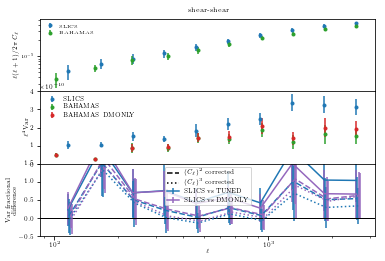

In [631]:
probes = ["shear"]#, "y"]
model = "CVAE_fid"

model2label = {"SLICS"       : "SLICS",
               "CGAN_fid"       : "CGAN",
               "CVAE_fid_drop1"       : "CVAE no z=0",
              "CGAN_fid_drop1"       : "CGAN no z=0"}
model2color = {"SLICS"      : "C0",
               "CVAE_fid"      : "C0",
               "CVAE_fid_drop1" : "C0",
               "CGAN_fid"      : "C1",
               "CGAN_fid_drop1" : "C1",}
model2ls = {"SLICS"      : "-",
            "CVAE_fid"      : "-",
            "CVAE_fid_drop1" : "--",
            "CGAN_fid"      : "-",
            "CGAN_fid_drop1" : "--",}

    
LOS_range = list(range(100,200))
# LOS_range = range()
ell_cut = 1
ell = ell_of_L[10.0][ell_cut:]
area_scaling = 4

for i, probe_1 in enumerate(probes):
    for probe_2 in probes[i:]:
        fig, ax = plt.subplots(3,1, sharex=True)
        fig.subplots_adjust(hspace=0)
        
        for model in ["SLICS",]:# "CGAN_fid", "CVAE_fid_drop1", "CGAN_fid_drop1"]:
            if True:#probe_1 == "y" or probe_2 == "y":
                u = ell*(ell+1)/(2*pi)
                y = np.array([Cl[model][LOS][f"{probe_1}-{probe_2}"] for LOS in LOS_range])[:,ell_cut:]
#                 ax[0].plot(ell, (u*y).T, alpha=0.2, c=model2color[model])
                ax[0].errorbar(ell, u*y.mean(axis=0), u*y.std(axis=0, ddof=1),
                              ls="none", marker="o", ms=3, 
                            c=model2color[model], label=model2label[model])
                
                u = ell**4
                var_std = np.sqrt(bootstrap_var(y, n=100))
                ax[1].errorbar(ell, u*y.var(axis=0, ddof=1), u*var_std,
                              ls="none", marker="o", ms=3, 
                              c=model2color[model], label=model2label[model])

            ell_BAHAMAS = Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["ell"]
            u = ell_BAHAMAS*(ell_BAHAMAS+1)/(2*pi)
            ax[0].errorbar(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["mean"], u*Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["std"]/np.sqrt(area_scaling), 
                        c="C2", ls="none", marker="o", ms=3, label="BAHAMAS")
#             ax[0].plot(ell_BAHAMAS, (u*Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["LOS"]).T, c="C1", alpha=0.2)
        #     ax.plot(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-y"]["mean"], c="C1", label="Hydrodynamical\nsimulation")

            ax[0].tick_params(axis='both', labelsize="small")
            ax[0].legend(fontsize="small", frameon=False)
            ax[0].set_xscale("log")
            ax[0].set_yscale("log")
            ax[0].set_title(f"{probe_1}-{probe_2}")

            u = ell_BAHAMAS**4
            var_std = np.sqrt(bootstrap_var(Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["LOS"], n=100,
                                            func=scaled_var, func_kwargs={"scale":1/area_scaling}))
            ax[1].errorbar(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["var"]/area_scaling, u*var_std, 
                        c="C2", ls="none", marker="o", ms=3, label="BAHAMAS")
            
            var_std = np.sqrt(bootstrap_var(Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["LOS"], n=100,
                                            func=scaled_var, func_kwargs={"scale":1/area_scaling}))
            ax[1].errorbar(ell_BAHAMAS, u*Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["var"]/area_scaling, u*var_std, 
                        c="C3", ls="none", marker="o", ms=3, label="BAHAMAS DMONLY")
#             ratio = y.mean(axis=0)/Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["mean"]-1
#             ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["LOS"]],
#                                               n=100, func=ratio_of_mean, func_kwargs={}))
#             ax[1].errorbar(ell, ratio, ratio_std,
#                            c=model2color[model], ls=model2ls[model])
#             ax[1].axhline(0.0, c="k", lw=1)

            ratio = area_scaling*y.var(axis=0, ddof=1)/Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["var"]-1
            ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["LOS"]],
                                              n=100, func=ratio_of_var, func_kwargs={"scale":area_scaling}))
            ax[2].errorbar(ell, ratio, ratio_std,
                           c=model2color[model], ls=model2ls[model], label="SLICS vs TUNED")
            
            ratio = area_scaling*y.var(axis=0, ddof=1)/Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["var"]-1
            ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["LOS"]],
                                              n=100, func=ratio_of_var, func_kwargs={"scale":area_scaling}))
            ax[2].errorbar(ell, ratio, ratio_std,
                           c="C4", ls=model2ls[model], label="SLICS vs DMONLY")
            
            mean_correction = (Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["mean"]/y.mean(axis=0))**2
            ratio = mean_correction*area_scaling*y.var(axis=0, ddof=1)/Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["var"]-1
            ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["LOS"]],
                                              n=100, func=ratio_of_var, func_kwargs={"scale":area_scaling*mean_correction}))
            ax[2].errorbar(ell*1.01, ratio, ratio_std,
                           c=model2color[model], ls="--")
            
            mean_correction = (Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["mean"]/y.mean(axis=0))**3
            ratio = mean_correction*area_scaling*y.var(axis=0, ddof=1)/Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["var"]-1
            ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-{probe_2}"]["LOS"]],
                                              n=100, func=ratio_of_var, func_kwargs={"scale":area_scaling*mean_correction}))
            ax[2].errorbar(ell*1.02, ratio, ratio_std,
                           c=model2color[model], ls=":")
            
            mean_correction = (Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["mean"]/y.mean(axis=0))**2
            ratio = mean_correction*area_scaling*y.var(axis=0, ddof=1)/Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["var"]-1
            ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["LOS"]],
                                              n=100, func=ratio_of_var, func_kwargs={"scale":area_scaling*mean_correction}))
            ax[2].errorbar(ell*1.03, ratio, ratio_std,
                           c="C4", ls="--")
            
            mean_correction = (Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["mean"]/y.mean(axis=0))**3
            ratio = mean_correction*area_scaling*y.var(axis=0, ddof=1)/Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["var"]-1
            ratio_std = np.sqrt(bootstrap_var([y, Cl_BAHAMAS[f"{probe_1}-{probe_2}-DMONLY"]["LOS"]],
                                              n=100, func=ratio_of_var, func_kwargs={"scale":area_scaling*mean_correction}))
            ax[2].errorbar(ell*1.04, ratio, ratio_std,
                           c="C4", ls=":")

            ax[2].plot([], [], ls="--", c="k", label=r"$(C_\ell)^2$ corrected")
            ax[2].plot([], [], ls=":", c="k", label=r"$(C_\ell)^3$ corrected")
            
        ax[1].legend(frameon=False)
        
        ax[2].axhline(0.0, c="k", lw=1)
        ax[2].set_ylim(-0.5, 1.5)
        
        ax[2].legend()
        
        ax[2].set_xlabel(r"$\ell$", labelpad=0.1, size="medium")
        ax[0].set_ylabel(r"$\ell(\ell+1)/2\pi\ C_\ell$", labelpad=0.1, size="medium")
#         ax[1].set_ylabel("Mean fractional\ndifference", labelpad=0.1, size="medium")
        ax[1].set_ylabel(r"$\ell^4\mathrm{Var}$", labelpad=0.1, size="medium")
        ax[2].set_ylabel("Var fractional\ndifference", labelpad=0.1, size="medium")

        fig.savefig(f"../plots/SLICS_vs_BAHAMAS_{probe_1}-{probe_2}.pdf")
        
        

## Contribution per redshift

In [ ]:

delta_filenames = glob.glob(os.path.join("../data/training_data/SLICS/delta/", f"*delta.dat_bicubic_LOS400"))

# These are the redshifts of the mid-points of the slices
z_SLICS = [float(z[:z.find("delta")]) for z in [os.path.split(f)[1] for f in delta_filenames]]
z_SLICS = np.array(sorted(z_SLICS))

print("SLICS redshifts:", z_SLICS)

Omega_m = 0.2905
Omega_b = 0.0473
Omega_L = 0.7095
h = 0.6898
sigma_8 = 0.826
n_s = 0.969
cosmo_SLICS = ccl.Cosmology(Omega_c=(1-Omega_L-Omega_b), Omega_b=Omega_b, Omega_k=0,
                            h=h, sigma8=sigma_8, n_s=n_s, m_nu=0.0)

n_dropped_planes = 1

for i, LOS in enumerate(range(410, 420)):
    print("LOS: ", LOS)
    kappa_map = np.fromfile(f"../data/training_data/SLICS/kappa/KiDS450/kappa_KiDS450_tomo0.dat_LOS{LOS}", dtype=np.float32).reshape(7745, -1, order="F")
    kappa_map = kappa_map[::5,::5]
    kappa_map *= 64
    
    for model in ["CVAE_fid", "CGAN_fid"]:
        print("  Model : ", model)
        with open(f"../data/training_data/SLICS/tSZ/{model2label[model]}/pressure_planes_{LOS}.pickle", "rb") as f:
            pressure_planes = pickle.load(f)

        for z_idx in range(n_dropped_planes+1):
            print("    Planes dropped: ", z_idx)
            m = f"{model}_drop{z_idx}"
            if m not in Cl:
                Cl[m] = {}
            if LOS not in Cl[m]:
                Cl[m][LOS] = {}

            y_map = baryon_painter.process_SLICS.create_y_map(pressure_planes[z_idx:], 
                                                              z_SLICS[z_idx:], 
                                                              resolution=1549, map_size=10.0, 
                                                              cosmo=cosmo_SLICS, order=5, 
                                                              verbose=False)

            Cl[m][LOS]["shear-y"], _, ell, _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                          y_map, kappa_map, 
                                                          box_size=(10/180*pi, 10/180*pi),
                                                          n_bin=10, ell_min=100, ell_max=3000, logspaced=True)

            Cl[m][LOS]["y-y"], _, ell, _, _ = cosmotools.pseudo_Cls.calculate_pseudo_Cl(
                                                          y_map, y_map, 
                                                          box_size=(10/180*pi, 10/180*pi),
                                                          n_bin=10, ell_min=100, ell_max=3000, logspaced=True)
        
        
        
        
        
    